# CSCI 3343 Lab 3: Pytorch for Linear Regression and Classification

**Posted:** Monday, September 27, 2021

**Due:** Monday, October 4, 2021 (11:59 am)

__Total Points__: 0.5 (extra pts for the final grade)

__Name__:
[Your first name] [Your last name], [Your BC username]

(e.g. Donglai Wei, weidf)

__Submission__: please rename the .ipynb file as __\<your_username\>_lab3.ipynb__ before you submit it to canvas. Example: weidf_lab3.ipynb.

Acknowledgement: Tongzhou Wang (MIT course 6.869)

#Introduction


## Colab setup: running in GPU session
Runtime -> Change runtime type -> Hardware accelerator -> GPU

# Part 1. PyTorch Basics

We will explain how to implement machine learning building blocks (model, loss, and optimization) in PyTorch. Then, you will be able to redo the "college entrance classification" problem ([Lab 2, Part 3](https://colab.research.google.com/drive/1sobb8ZRUbgxzUyJDcoMh7vlHckRrj5qe)) with just a few lines of code!

## 1.0 Overview

### What is PyTorch?
1. A Python GPU-accelerated tensor library (NumPy, but faster)
2. Differentiable Programming with dynamic computation graphs
3. Flexible and efficient **neural network** library
4. Python-first framework (easy to integrate with other Python libraries, debug, and extend)
  + Quick conversion from & to NumPy array, integration with other Python libs.
  + Your favorite Python debugger.
  + Adding custom ops with Python/c++ extension. 
  + Running in purely c++ environment with the c++ API.

Useful links:

+ PyTorch documentation: https://pytorch.org/docs/stable/index.html
  -  Most math operations can be found as `torch.*` or `Tensor.*`.
+ [Optional] PyTorch official tutorials: https://pytorch.org/tutorials/
  - Transfer learning tutorial: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
+ [Optional] PyTorch examples: https://github.com/pytorch/examples/
  - DCGAN, ImageNet training, Reinforcement Learning, etc.

### PyTorch Installation

In [ ]:
# install torch and torchvision (a utility library for computer vision that provides many public datasets and pre-trained models)
!pip install torch torchvision

## 1.1 Data: GPU-accelerated Tensor Library

The syntax of the torch tensor library is similar to that of numpy.

In [ ]:
import torch

In [ ]:
# Create a 3x5 matrix filled with zeros
x = torch.zeros(3, 5)
print(x)

In [ ]:
# Create a 3x5 matrix filled with random values from a standard normal distribution
y = torch.randn(3, 5)
print(y)

In [ ]:
# Shape manipulations
print('\n.t()  (transpose): ')
print(y.t())

print('.reshape(5, 3): ')
print(y.reshape(5, 3))

In [ ]:
# Slicing
print(y[1:])

# Slicing + select every two elements
print(y[1:, ::2])

In [ ]:
# Basic arithmetics
print(x + 2)

In [ ]:
print(y * (x + 2))

In [ ]:
print((y * (x + 2)).exp())

#### GPU Acceleration

Everything can be run on a GPU

First, let us create a [`torch.device`](https://pytorch.org/docs/stable/tensor_attributes.html#torch-device) object representing a GPU device.

In [ ]:
cuda0 = torch.device('cuda:0')  # pick the GPU at index 0

In [ ]:
# Move a tensor from CPU to GPU
# NOTE: the first time you access a GPU, a context is created so this may take a
# few seconds. But subsequent uses will be fast.

cuda_y = y.to(cuda0)
print(cuda_y)

In [ ]:
# Or directly creating a tensor on GPU
cuda_x = torch.zeros(3, 5, device=cuda0)
print(cuda_x)

In [ ]:
# All functions and methods work on GPU tensors
print((cuda_y * (cuda_x + 2)).exp())  # values match the CPU results above!

### NumPy Bridge

Converting a `torch.Tensor` to a `np.ndarray` and vice versa is a breeze.

The `torch.Tensor` and `np.ndarray` will share their underlying memory locations (if the `torch.Tensor` is on CPU and `dtype` is the same), and changing one will change the other.

In [ ]:
import numpy as np

In [ ]:
# convert a torch tensor into a numpy array
x = torch.randn(5)
x_np1 = x.numpy()
x_np2 = np.asarray(x)

print(x)
print(x_np1)
print(x_np2)

In [ ]:
# convert a numpy array into a torch tensor

a = np.random.randn(3, 4)
a_pt = torch.as_tensor(a)
print(a)
print(a_pt)

In [ ]:
# the resulting CPU Tensor shares memory with the array!
# change the tensor array -> change the orignial numpy array
# if you want a different copy: a_pt = torch.as_tensor(a.copy())

a_pt[0] = -1
print(a)

## 1.2 Model+Loss: Flexible and Efficient Neural Network Library

The [`torch.nn`](https://pytorch.org/docs/stable/nn.html) and [`torch.optim`](https://pytorch.org/docs/stable/optim.html) packages provide many efficient implementations of neural network components:
  + Affine layers and [activation functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)
  + Normalization methods
  + [Initialization schemes](https://pytorch.org/docs/stable/nn.html#torch-nn-init)
  + [Loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions)
  + [Embeddings](https://pytorch.org/docs/stable/nn.html#sparse-layers)
  + [Distributed and Multi-GPU training](https://pytorch.org/docs/stable/nn.html#dataparallel-layers-multi-gpu-distributed)
  + [Gradient-based optimizers](https://pytorch.org/docs/stable/optim.html)
  + [Learning rate schedulers](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)
  + etc.

### Implement One-layer MLP

We will use the [fully connected linear layer (`nn.Linear`)](https://pytorch.org/docs/stable/nn.html#torch.nn.Linear) and. 
A fc layer performs an affine transform with a 2D weight parameter $\mathbf{w}$ and a 1D bias parameter $\mathbf{b}$:

$$ f(\mathbf{x}) = \sigma(\mathbf{w}^\mathrm{T} \mathbf{x} + \mathbf{b}).$$

#### Step 1. Linear layer

In [ ]:
# all popular neural network layers
import torch.nn as nn 
# handy for simple functions
import torch.nn.functional as F

In [ ]:
# input x: 1D array of size 4
# output: 1D array of size 8
fc = nn.Linear(in_features=4, out_features=8)
print(fc)

In [ ]:
# It has two parameters, the weight and the bias
# These parameters by default have `requires_grad=True`, so they will collect gradients!
for name, p in fc.named_parameters():
    print('param name: {}\t shape: {}'.format(name, p.shape))

In [ ]:
# w
print(fc.weight)

In [ ]:
# b
print(fc.bias)

#### Step 2. Sigmod Function (Logistic function)

In [ ]:
# Let's construct an input tensor with 2 dimensions:
#   - batch dimensionsize: 2
#   - input size: 4
x = torch.randn(2, 4)

# w*x+b
result_linear = fc(x)
# sigma(w*x+b)
result_logistic = F.sigmoid(result_linear)
print("linear layer output: range=[-\infty, \infty]")
print(result_linear)
print("logistic output: range=[0, 1]")
print(result_logistic)



#### Step 3. MSE Loss Function

In [ ]:
# Say (arbitrarily) we want the layer to behave like f(x) = x^2
target = result_linear **2

# Let's try MSE loss
loss = F.mse_loss(result_logistic, target)
print(loss)

## 1.3 Optimization: Autograd and Optimizer

#### Gradient Computation
PyTorch keeps track of your computations and the gradient is automatically computed!

In [ ]:
# Compute gradients
loss.backward()
print(fc.bias.grad)

#### Optimizer

We can code up a naive optimizer with manual gradient updates like before.

In [ ]:
# We can manually perform GD via a loop
print('bias before GD', fc.bias)
lr = 0.5
with torch.no_grad():  
    # this context manager tells PyTorch that we don't want ops inside to be 
    # tracked by autograd!
    # o/w PyTorch will try to automatically compute the gradient of this gradient operation too.
    for p in fc.parameters():
        p -= lr * p.grad
        
print('bias after one-step GD', fc.bias)

More easily, we can use the provided [`torch.optim`](https://pytorch.org/docs/stable/optim.html#torch.optim) optimizers (e.g. GD+momentum and many advanced optimizers). We will see how to use the [`torch.optim.SGD`](https://pytorch.org/docs/stable/optim.html#torch.optim.SGD) optimizer in a second!

## Exercise 1. Redo Lab 2-Part 3 in PyTorch

**(a) [TODO] Data.** We will
- download and pre-procoss the dataset (x,y)
- divide them into train, val, and test sets in a 6:2:2 ratio
- [TODO] convert from numpy to pytorch tensor

In [ ]:
# download data
import numpy as np
import pandas as pd
import torch

url = 'https://raw.githubusercontent.com/BlohmLab/MLtutorials/week3/data/marks.txt'
data = pd.read_csv(url, header=None)
Y = np.array(data.iloc[:,-1]).astype(np.float32).reshape([-1,1])

# by default, numpy arrays are float64, but pytorch tensor wants float32
X = np.array(data.iloc[:,:-1]).astype(np.float32)
# normalize the data for better learning
X = (X-X.mean(axis=0))/X.std(axis=0)

def data_split(N, ratio=[6,2,2]):
  # generate a shuffle array
  shuffle_idx = np.arange(N)
  np.random.shuffle(shuffle_idx)
  # divide into train-val-test by the ratio
  data_split = (np.cumsum(ratio)/float(sum(ratio))*N).astype(int)
  out_idx = [None] * len(ratio)
  out_idx[0] = shuffle_idx[:data_split[0]]
  for i in range(1,len(ratio)):
    out_idx[i] = shuffle_idx[data_split[i-1] : data_split[i]]
  return out_idx  

train_idx, val_idx, test_idx = data_split(len(Y))

X_train, Y_train = X[train_idx], Y[train_idx]
X_val, Y_val = X[val_idx], Y[val_idx]
X_test, Y_test = X[test_idx], Y[test_idx]

#### TODO: convert variables into pytorch tensors
X_train_pt, Y_train_pt = ???
X_val_pt, Y_val_pt = ???
X_test_pt, Y_test_pt = ???

**(b) [TODO] Model.** let's define the deep learning model!

In [ ]:
import torch.nn as nn 
import torch.nn.functional as F

class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        # define the layers and parameters
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        # this function will be called to process the input data
        #### TODO: implement \sigma(Wx+b)        
        return outputs

# create a model (parameters are initialized)
# input (size = 2): two exam scores (the bias param will take care of constant term)
# ouput (size = 1): accept or not
model = LogisticRegression(input_dim = 2, output_dim = 1)

# upload the model to GPU
# model.cuda()

**(c) Optimizer.** We will use all the data and SGD becomes the same as the gradient descent (GD).

In [ ]:
lr_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)

**(d) Training.** We wrote the training code for you! (well, only 4 important lines!)

In [ ]:
num_iter = 150
# training loop
for ii in range(num_iter):
    # 1. forward pass
    Y_hat = model(X_train_pt)
    
    # 2. compute loss
    loss = F.mse_loss(Y_hat, Y_train_pt)
    
    # 3. compute gradients
    loss.backward()
    
    # 4. gradient update
    optimizer.step()
    
    # add some printing
    if ii % 10 == 0:
        print('iteration {}\tloss {:.5f}'.format(ii, loss))

# if the torch tensor has "require_grad", need to detach it first
ww = model.linear.weight.detach().numpy()[0]
bb = model.linear.bias.detach().numpy()[0]

**(e) Evaluation.** We will first compute the accuray and plot the predicted decision boundary. Note that the model that fits the training data well, may still have much error on the val and test data.

In [ ]:
def compute_accuracy(model, x=X, y=Y):
    """function that compares predicted y to true y and returns accuracy"""
    y_pred = model(x)>0.5
    accuracy = (y_pred == y).sum()/len(y)
    return accuracy 

print('Train acc:', compute_accuracy(model, X_train_pt, Y_train_pt))
print('Val acc:', compute_accuracy(model, X_val_pt, Y_test_pt))
print('Test acc:', compute_accuracy(model, X_val_pt, Y_test_pt))

In [ ]:
def plot_logistic_regression(fig, param_W, param_b, x=X, y=Y, subp=111, title='train'):
  # plot original data
  X_admitted = x[y==1,:]
  X_rejected = x[y==0,:]
  
  ax = fig.add_subplot(subp)
  ax.scatter(X_admitted[:,0],X_admitted[:,1])
  ax.scatter(X_rejected[:,0],X_rejected[:,1])
  ax.set_xlabel('Mark 0')
  ax.set_ylabel('Mark 1')
  ax.legend(('Accept','Reject'))

  # plot the decision boundary
  xx = np.linspace(-2, 2,100)
  yy = -param_W[0]/param_W[1]*xx - param_b/param_W[1]
  ax.plot(xx,yy,'g-')
  plt.title(title)
  

fig = plt.figure()
plot_logistic_regression(fig, ww, bb, X_train, Y_train[:,0], 131, 'train')
plot_logistic_regression(fig, ww, bb, X_val, Y_val[:,0], 132, 'val')
plot_logistic_regression(fig, ww, bb, X_test, Y_test[:,0], 133, 'test')
plt.show()



# Part 2. Polynomial Regression (Exercise 2)

Linear regression itself can be simple, but it can be used together with hand-crafted features and become a bit more powerful. 
As the solution can be computed with an analytical closed-form, **we will just use numpy library**.

**(a) Data.** We use a 2nd-order polynomial function and Gaussian noise to generate the ground truth regression values.

In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt

#np.random.seed(int(time.time()))
np.random.seed(123)

# gt polynomial: (x-5)^2
num_pt = 10

X = np.random.uniform(4, 10, num_pt).reshape(-1,1)
Y = (X - 5)**2 + 0.5 *np.random.normal(0, 1, num_pt).reshape(-1,1)

# for visualization
XX = np.linspace(4,10,100).reshape(-1,1)

In [ ]:
def data_split(N, ratio=[6,2,2]):
  # generate a shuffle array
  shuffle_idx = np.arange(N)
  np.random.shuffle(shuffle_idx)
  # divide into train-val-test by the ratio
  data_split = (np.cumsum(ratio)/float(sum(ratio))*N).astype(int)
  out_idx = [None] * len(ratio)
  out_idx[0] = shuffle_idx[:data_split[0]]
  for i in range(1,len(ratio)):
    out_idx[i] = shuffle_idx[data_split[i-1] : data_split[i]]
  return out_idx  

train_idx, val_idx, test_idx = data_split(len(Y))

X_train, Y_train = X[train_idx], Y[train_idx]
X_val, Y_val = X[val_idx], Y[val_idx]
X_test, Y_test = X[test_idx], Y[test_idx]


def plot_data(split = 'train', subp=111):
  plt.subplot(subp)
  if split == 'train':
    plt.plot(X_train, Y_train, 'r.')
  elif split == 'val':
    plt.plot(X_val, Y_val, 'bx')
  elif split == 'test':
    plt.plot(X_test, Y_test, 'go')
  plt.xlim([4,10])  
  plt.title(split)

plot_data()
plt.show()

**(b) [TODO] K=1:** Implement the linear regression.

**Course material: Lecture 7, page 18**

In [ ]:
def MSE(y, y_hat):
  # MSE loss to measure the regression distance
  return ((y-y_hat)**2).mean()


def train_LR(x,y):
  #### TODO: complete the analytical solution for linear regression  
  return ???

# concatenate the all one array for the bias term
X1_train = np.hstack([X_train, np.ones([X_train.shape[0],1])])
f_K1 = train_LR(X1_train, Y_train)
mse_K1_train = MSE(f_K1(X1_train), Y_train)

X1_val = np.hstack([X_val, np.ones([X_val.shape[0],1])])
mse_K1_val = MSE(f_K1(X1_val), Y_val)


X1_test = np.hstack([X_test, np.ones([X_test.shape[0],1])])
mse_K1_test = MSE(f_K1(X1_test), Y_test)

print('K=1: train-MSE=%.2f' % mse_K1_train)
print('K=1: val-MSE=%.2f' % mse_K1_val)
print('K=1: test-MSE=%.2f' % mse_K1_test)

XX1 = np.hstack([XX, np.ones([XX.shape[0],1])])
plot_data('train', 131)
plt.plot(XX, f_K1(XX1), 'k-')
plot_data('val', 132)
plt.plot(XX, f_K1(XX1), 'k-')
plot_data('test', 133)
plt.plot(XX, f_K1(XX1), 'k-')

plt.show()


**(c) [TODO] K=2:** Implement a polynomial regression function. It can be seen as first create features from input X and then apply linear regression

**Course material: Lab 3, page 23**

In [ ]:
def LR_K2(x, y=None, f=None):
  #### TODO: complete the feature matrix
  x_feat = ???
  if f is None:
    f = train_LR(x_feat, y)
  if y is None: # test-time value
    return f(x_feat)
  mse = MSE(f(x_feat), y)
  return f, mse

# train the model
f_K2, mse_K2_train = LR_K2(X_train, Y_train)
# evaluate the model

_, mse_K2_val = LR_K2(X_val, Y_val, f_K2)
_, mse_K2_test = LR_K2(X_test, Y_test, f_K2)


print('K=2: train-MSE=%.2f' % mse_K2_train)
print('K=2: val-MSE=%.2f' % mse_K2_val)
print('K=2: test-MSE=%.2f' % mse_K2_test)

plot_data('train', 131)
plt.plot(XX, LR_K2(XX, f=f_K2), 'k-')
plot_data('val', 132)
plt.plot(XX, LR_K2(XX, f=f_K2), 'k-')
plot_data('test', 133)
plt.plot(XX, LR_K2(XX, f=f_K2), 'k-')

plt.show()


**(d) [TODO] Arbitrary K:** Implement a polynomial regression function with an arbitrary number K.
**Course material: Lab 3, page 23**

In [ ]:
def LR_KK(x, y=None, K=2, f=None):
  x_feat = [None] * (K+1)
  for i in range(K+1):
    #### TODO: complete each column in the feature matrix
    x_feat[i] = ???
  x_feat = np.hstack(x_feat)

  if f is None:
    f = train_LR(x_feat, y)
  if y is None: # test-time value
    return f(x_feat)
  mse = MSE(f(x_feat), y)
  return f, mse

# Let K=10
# train the model
f_K10, mse_K10_train = LR_KK(X_train, Y_train, 10)
# evaluate the model

_, mse_K10_val = LR_KK(X_val, Y_val, 10, f_K10)
_, mse_K10_test = LR_KK(X_test, Y_test, 10, f_K10)


print('K=10: train-MSE=%.2f' % mse_K10_train)
print('K=10: val-MSE=%.2f' % mse_K10_val)
print('K=10: test-MSE=%.2f' % mse_K10_test)

plot_data('train', 131)
plt.plot(XX, LR_KK(XX, K=10, f=f_K10), 'k-')
plot_data('val', 132)
plt.plot(XX, LR_KK(XX, K=10, f=f_K10), 'k-')
plot_data('test', 133)
plt.plot(XX, LR_KK(XX, K=10, f=f_K10), 'k-')

plt.show()


(e) Plot generalization error

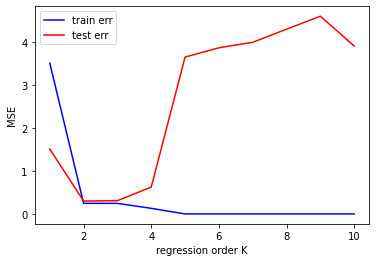

In [ ]:
Ks = range(1, 11)
train_err = np.zeros(len(Ks))
test_err = np.zeros(len(Ks))
for i,K in enumerate(Ks):
  f, train_err[i] = LR_KK(X_train, Y_train, K)
  _, test_err[i] = LR_KK(X_test, Y_test, K, f)



plt.plot(Ks, train_err,'b-')
plt.plot(Ks, test_err,'r-')
plt.legend(('train err','test err'))
plt.xlabel('regression order K')
plt.ylabel('MSE')
plt.show()
